In [1]:
import io
import os
import sys
import random

# for debugging
from PIL import Image
from matplotlib import pyplot as plt

# decord for fast frame extraction
from decord import VideoReader
from decord import cpu, gpu

# cv2 to draw on frames and putting them together
import cv2
import numpy as np

# moviepy for handling audio
from moviepy.editor import *

# import u2net
import u2net

Loading U-2-Net...
Cuda is available
U-2-Net is ready


In [2]:
# convert PIL <=> OpenCV
# https://qiita.com/derodero24/items/f22c22b22451609908ee


def pil2cv(image):
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2:  # monochrome
        print('[pil2cv] monochrome')
        pass
    elif new_image.shape[2] == 3:  # color
        #print('[pil2cv] RGB => BGR')
        #new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
        pass
    elif new_image.shape[2] == 4:  # convertion
        print('[pil2cv] RGBA => BGRA')
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    return new_image


def cv2pil(image):
    new_image = image.copy()
    if new_image.ndim == 2:  # monochrome
        print('[cv2pil] monochrome')
        pass
    elif new_image.shape[2] == 3:  # color
        #print('[cv2pil] RGB => BGR')
        #new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
        pass
    elif new_image.shape[2] == 4:  # convertion
        print('[cv2pil] RGBA => BGRA')
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGRA2RGBA)
    new_image = Image.fromarray(new_image)
    return new_image


In [3]:
def create_keying_background(width, height, rgb_color=(0, 0, 0)):
    """Create new image(numpy array) filled with certain color in RGB"""
    # Create black blank image
    image = np.zeros((height, width, 3), np.uint8)

    # Since OpenCV uses BGR, convert the color first
    color = tuple(reversed(rgb_color))
    # Fill image with color
    image[:] = color

    return image

In [4]:
# change to gpu(0) for faster processing
vr = VideoReader('video.mp4', ctx=cpu(0))

frame = vr[0]
height, width, layers = frame.shape

print(f'Input frame {height}x{width}x{layers}')
print(f'Frame cv2 format {frame.dtype}')
#print(f'Frame cv2 values between ' + str(np.amin(frame)) + ' and ' + str(np.amax(frame)))
print(f'Frame cv2 shape {frame.shape}')

frame_np = frame.asnumpy()
print(f'Frame numpy format {frame.dtype}')
#print(f'Frame numpy values between ' + str(np.amin(frame)) + ' and ' + str(np.amax(frame)))
print(f'Frame numpy shape {frame.shape}')

Input frame 960x720x3
Frame cv2 format uint8
Frame cv2 shape (960, 720, 3)
Frame numpy format uint8
Frame numpy shape (960, 720, 3)


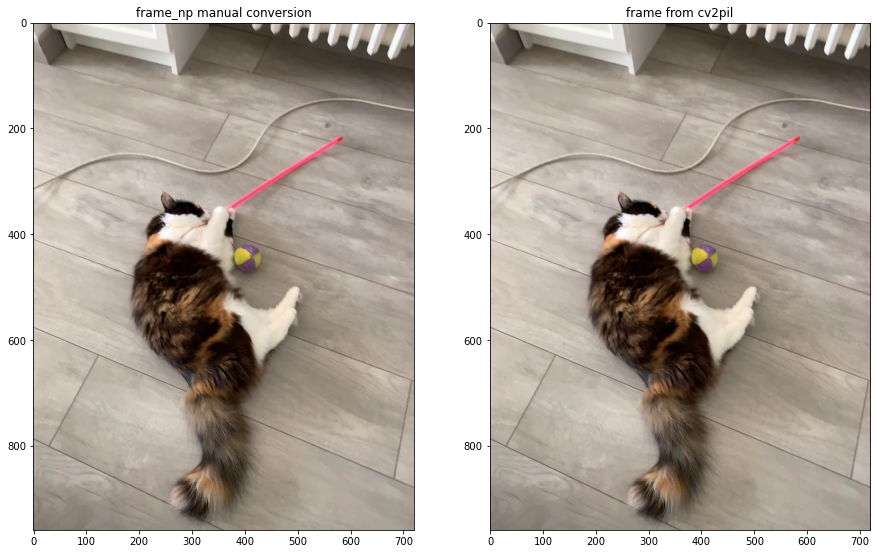

In [5]:
f = plt.figure(figsize = (15,15))

f.add_subplot(1,2,1)
preview = cv2.cvtColor(frame_np, cv2.COLOR_BGR2HSV)
plt.title('frame_np manual conversion')
plt.imshow(frame_np)

f.add_subplot(1,2,2)
preview = cv2pil(frame.asnumpy())
plt.title('frame from cv2pil')
plt.imshow(preview)

plt.show(block=True)

In [6]:
mask_np = u2net.run(frame_np)

print(f'Mask numpy format {mask_np.dtype}')
print(f'Mask numpy values between ' + str(np.amin(mask_np)) + ' and ' + str(np.amax(mask_np)))
print(f'Mask numpy shape {mask_np.shape}')

Mask numpy format float32
Mask numpy values between 0.0 and 1.0
Mask numpy shape (320, 320)


In [7]:
# resize u2net output (320x320) to original frame resolution
mask_cv2 = cv2.resize(mask_np, (width, height))

print(f'Mask cv2 format {mask_cv2.dtype}')
print(f'Mask cv2 values between ' + str(np.amin(mask_cv2)) + ' and ' + str(np.amax(mask_cv2)))
print(f'Mask cv2 shape {mask_cv2.shape}')


Mask cv2 format float32
Mask cv2 values between 9.366091e-13 and 1.0
Mask cv2 shape (960, 720)


In [8]:
# scale mask values from the range [0, 1] to [0, 255]
mask_cv2_uint8 = (mask_cv2 * 255).astype(np.uint8)
ret, mask_cv2_uint8 = cv2.threshold(mask_cv2_uint8, 10, 255, cv2.THRESH_BINARY)

print(f'Mask cv2 uint8 shape {mask_cv2_uint8.shape}')
print(f'Mask cv2 uint8 format {mask_cv2_uint8.dtype}')
print(f'Mask cv2 uint8 values between ' + str(np.amin(mask_cv2_uint8)) + ' and ' + str(np.amax(mask_cv2_uint8)))

Mask cv2 uint8 shape (960, 720)
Mask cv2 uint8 format uint8
Mask cv2 uint8 values between 0 and 255


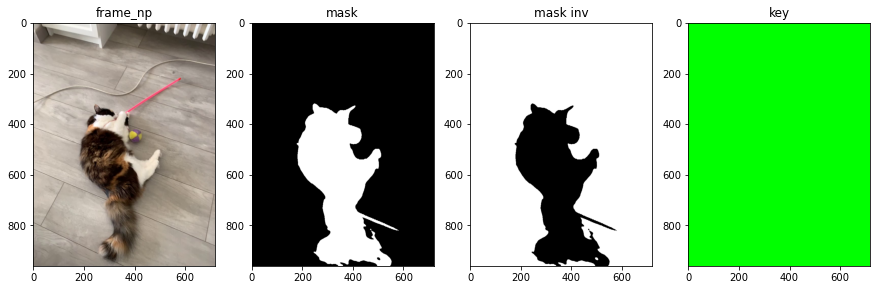

In [9]:
f = plt.figure(figsize = (15,15))

f.add_subplot(1,4,1)
preview = cv2.cvtColor(frame_np, cv2.COLOR_BGR2HSV)
plt.title('frame_np')
plt.imshow(frame_np)

f.add_subplot(1,4,2)
plt.title('mask')
plt.imshow(cv2.cvtColor(mask_cv2_uint8, cv2.COLOR_GRAY2RGB))

f.add_subplot(1,4,3)
mask_cv2_uint8_inv = cv2.bitwise_not(mask_cv2_uint8)
plt.title('mask inv')
plt.imshow(cv2.cvtColor(mask_cv2_uint8_inv, cv2.COLOR_GRAY2RGB))

f.add_subplot(1,4,4)
# solid color image
keying_bg = create_keying_background(width, height, (0, 255, 0))
plt.title('key')
plt.imshow(keying_bg)

plt.show(block=True)

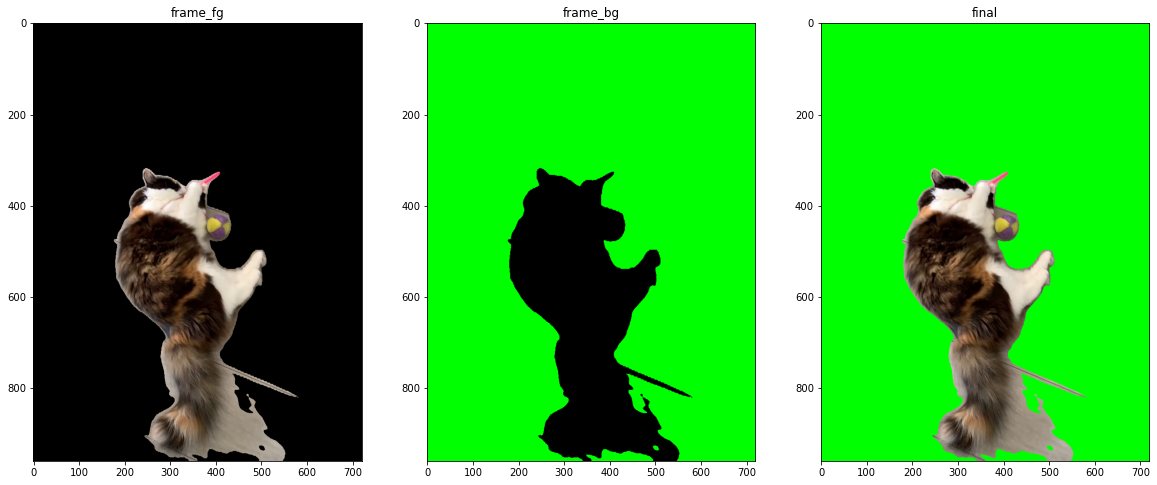

In [71]:
f = plt.figure(figsize = (20,20))

# apply mask to image
# https://note.nkmk.me/en/python-opencv-numpy-alpha-blend-mask/
frame_fg = cv2.bitwise_and(frame_np, frame_np, mask=mask_cv2_uint8)
frame_bg = cv2.bitwise_and(keying_bg, keying_bg, mask=mask_cv2_uint8_inv)

final = frame_fg + frame_bg

f.add_subplot(1,3,1)
plt.title('frame_fg')
plt.imshow(frame_fg)

f.add_subplot(1,3,2)
plt.title('frame_bg')
plt.imshow(frame_bg)

f.add_subplot(1,3,3)
plt.title('final')
plt.imshow(final)

plt.show()
